## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Double Click on any image to make it big

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import math
import os
import warnings
from random import randint
%matplotlib inline

## Camera calibration using chessboard images

First step is to take 20 to 30 pictures of a chessboard with the camera you will be using on the self driving car. I have placed these images inside `camera_calibration_images`. Then determine

- nx: Number of corners in any given row
- ny: Number of corners in any given column

<b>corners:</b> Points where two black and two white squares intersect.

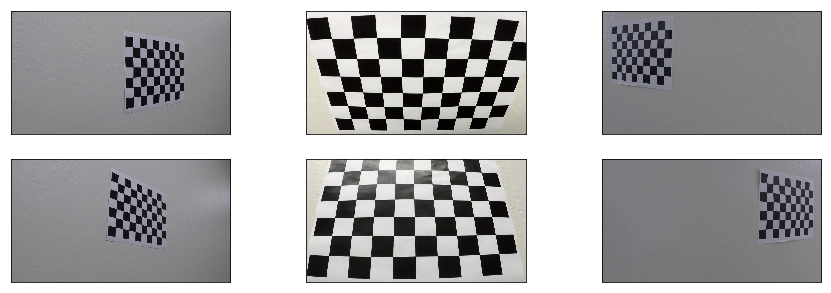

In [2]:
# Make a list of paths to calibration images
cal_img_paths = glob.glob(os.path.join("camera_calibration_images" , "calibration*.jpg"))

# Read and Display samples
plt.figure(figsize=(15, 5))  # width and heights in inches
for i in range( min(6,len(cal_img_paths) )):
    image = mpimg.imread(cal_img_paths[i])
    plt.subplot(2,3,i+1), plt.xticks([]), plt.yticks([])
    plt.imshow(image)

From the above images you can see that my chessboard has nx=9 , ny=6. Now let's define the object points to determine the [camera calibration parameters](https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html).

In [3]:
# Arrays to store object points and image points for each calibration image.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(ny,nx,0) in a column
nx, ny = 9, 6
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Step through the list and search for chessboard corners
for i in range(len(cal_img_paths)):
    image = mpimg.imread(cal_img_paths[i])
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points and image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Camera Calibration Parameters
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print("\n Matrix Coefficients \n", mtx)
print("\n Distortion Coefficients [k1 k2 p1 p2 k3] \n",dist)


 Matrix Coefficients 
 [[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

 Distortion Coefficients [k1 k2 p1 p2 k3] 
 [[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259867]]


## Distortion Correction

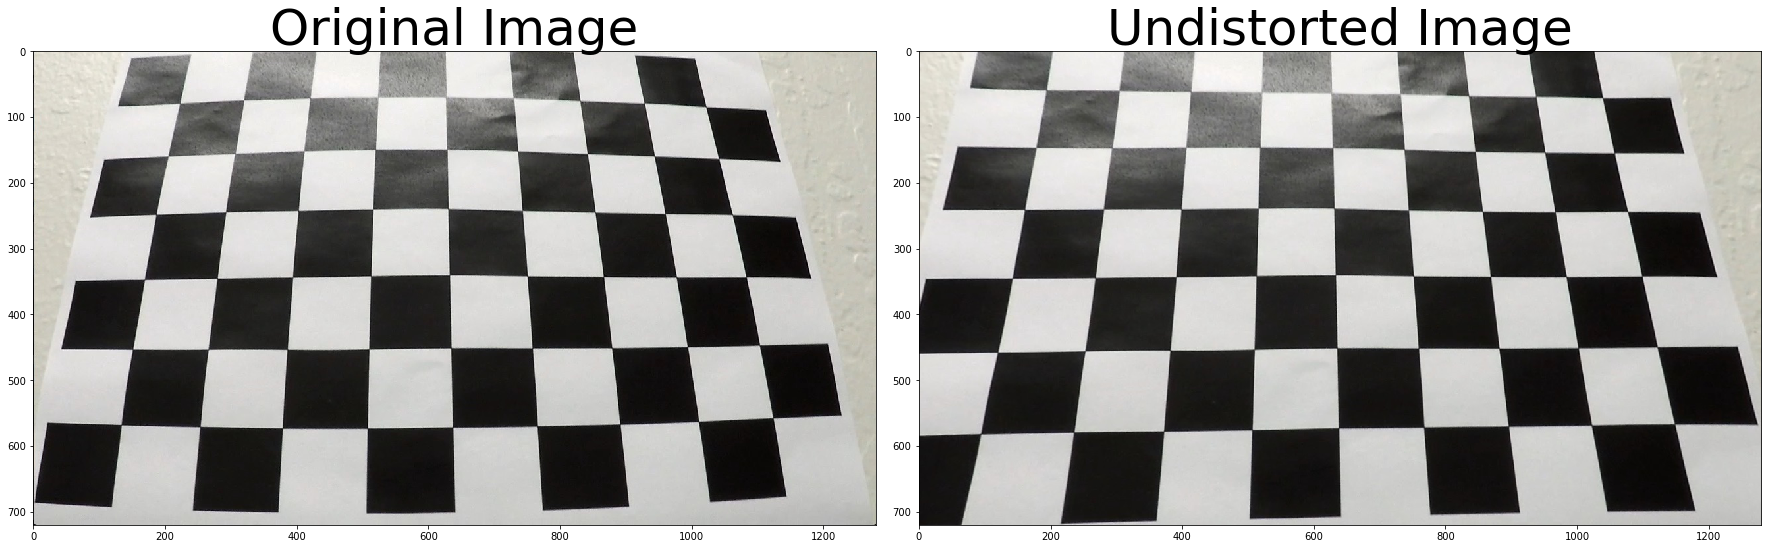

In [4]:
# Undistort random calibration image
indx   = randint(0,len(cal_img_paths)-1)
image  = mpimg.imread(cal_img_paths[indx])
undist = cv2.undistort(image, mtx, dist, None, mtx)

# Display
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))  # width and heights in inches
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Read in Test Images
In `Udacity_dataset` there is a `test_images` folder which contains 2 straight line images for aligning perspective transform and 6 other test images. 


 Location  : Udacity_dataset/test_images/straight_lines2.jpg 
 Dimensions: (720, 1280, 3)


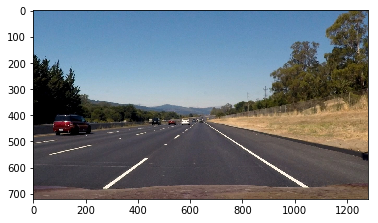

In [5]:
straight_line_test_images_paths = glob.glob(os.path.join("Udacity_dataset","test_images","straight*.jpg"))
test_images_paths = glob.glob(os.path.join("Udacity_dataset","test_images","test*.jpg"))
                              
# Read straight line image
image = mpimg.imread(straight_line_test_images_paths[0]) #first image from list

# Display
print('\n Location  :', straight_line_test_images_paths[0], '\n Dimensions:', image.shape)
plt.imshow(image)

## Apply Perspective Transformation
Next, you want to identify four source points for your perspective transform. The easiest way to do this is to investigate an image where the lane lines are straight. Try experimenting with different src points.

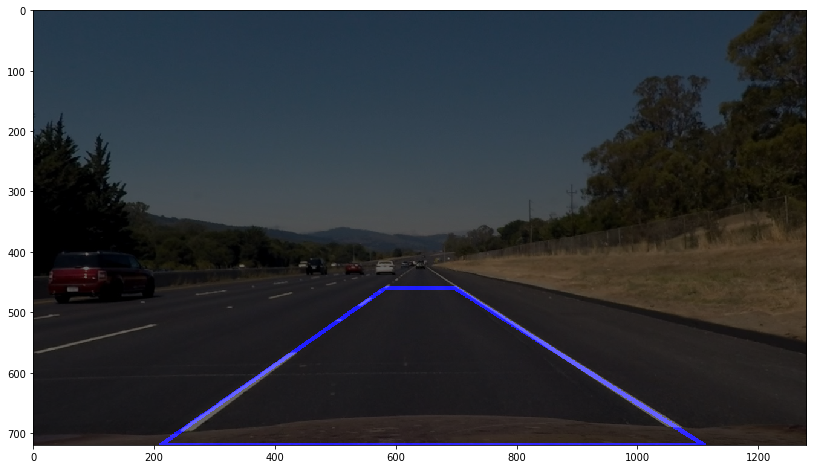

In [6]:
def draw_roi_box(img, vertices, color=[0, 0, 255], thickness=5):
    """
    Draw a contour around region of interest on img (binary or color)
    Vertices must be 2D array of coordinate pairs [[(x1,y1),...,(x4,y4)]]
    
    """
    # Create blank image: if not color yet then create "color" binary image
    if len(img.shape) == 2:         #if single channel
        img = np.dstack((img, img, img))
    img_to_draw = np.copy(img)*0
    
    # Draw the lines
    for vertex in vertices:   # used 'for' to get rid of 2D array
        cv2.line(img_to_draw, tuple(vertex[0]), tuple(vertex[1]), color, thickness)
        cv2.line(img_to_draw, tuple(vertex[1]), tuple(vertex[2]), color, thickness)
        cv2.line(img_to_draw, tuple(vertex[2]), tuple(vertex[3]), color, thickness)
        cv2.line(img_to_draw, tuple(vertex[3]), tuple(vertex[0]), color, thickness)
           
    # Add detected lanes to original img
    output_img = cv2.addWeighted(img_to_draw, 1, img, 0.4, 0) 
    return output_img


# Read straight line image
image = mpimg.imread(straight_line_test_images_paths[0]) #first image from list
image = cv2.undistort(image, mtx, dist, None, mtx)

# Obtain source points
height, width = image.shape[:2]
offset  = 20   # camera offset from center of car
bottom_left   =( width/2 -450 +offset   , height) 
upper_left    =( width/2 -58            , height/2+100)
upper_right   =( width/2 +58            , height/2+100)
bottom_right  =( width/2 +450 +offset   , height)
vertices = np.array([[bottom_left,upper_left,upper_right,bottom_right]], dtype=np.int32)

# Display
plt.figure(figsize=(15, 8))  # width and heights in inches
plt.imshow(draw_roi_box(image, vertices))

Now that we have acquired the source points let's apply the perspective transform

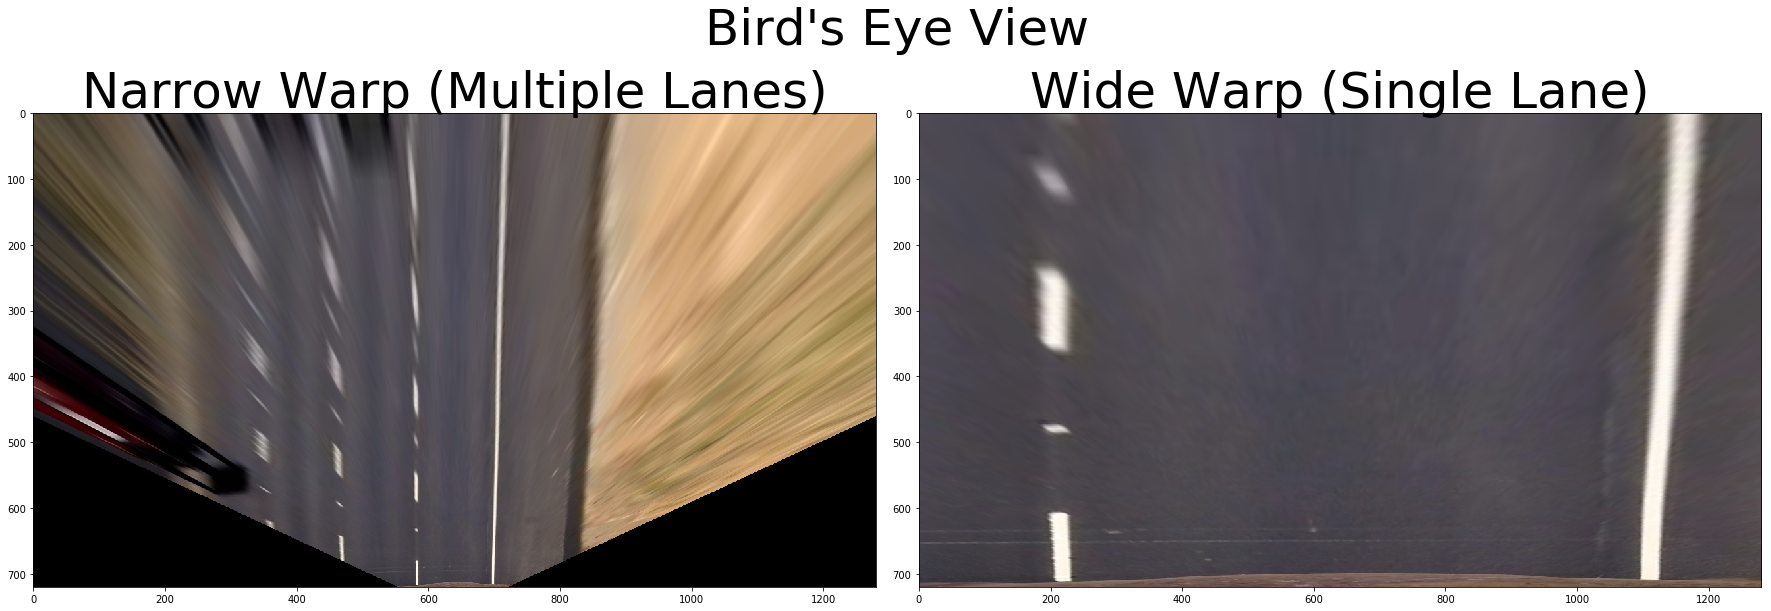

In [7]:
# Source Points
src = np.float32(vertices[0]) # with [0] we reduce one dimension

# Destination Points   
dst_wide = np.float32([bottom_left,
                   [bottom_left[0], 0],
                   [bottom_right[0],0],
                   bottom_right])
dst_narrow = np.float32([[upper_left[0],height],
                         upper_left,
                         upper_right,
                         [upper_right[0],height]])

# Perspective Transform Matrix
M_wide   = cv2.getPerspectiveTransform(src, dst_wide)
M_narrow = cv2.getPerspectiveTransform(src, dst_narrow)

# Warped Images
warped_wide   = cv2.warpPerspective(image, M_wide, (width,height))
warped_narrow = cv2.warpPerspective(image, M_narrow, (width,height))

# Display
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))  # width and heights in inches
f.tight_layout()
plt.suptitle("Bird's Eye View", fontsize=50)
ax1.set_title('Narrow Warp (Multiple Lanes)', fontsize=50)
ax1.imshow(warped_narrow)
ax2.set_title('Wide Warp (Single Lane)', fontsize=50)
ax2.imshow(warped_wide)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Convert to a Thresholded Binary Image
This section is based on this [Repo](https://github.com/laygond/EdgeDetection-and-ColorSpaces.git) which explores color spaces and edge detection techniques.

#### Helper Functions

In [8]:
def applyThresh(image, thresh=(0,255)):
    """
    Apply threshold to binary image. Setting to '1' pixels> minThresh & pixels <= maxThresh.
    """
    binary = np.zeros_like(image)
    binary[(image > thresh[0]) & (image <= thresh[1])] = 1
    return binary

def S_channel(image):
    """
    Returns the Saturation channel from an RGB image.
    """
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    return S
    
def sobel_X(image):
    """
    Applies Sobel in the x direction to an RGB image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.abs(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=3))
    sobelx     = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    return sobelx

def binary_pipeline(image):
    """
    Combination of color and gradient thresholds for lane detection. 
    Input image must be RGB
    """
    sobelx    = sobel_X(image)
    s_channel = S_channel(image)
    
    bin_sobelx    = applyThresh(sobelx, thresh=(20,100))
    bin_s_channel = applyThresh(s_channel, thresh=(90,255))
    
    return bin_sobelx | bin_s_channel

#### Binary Pipeline

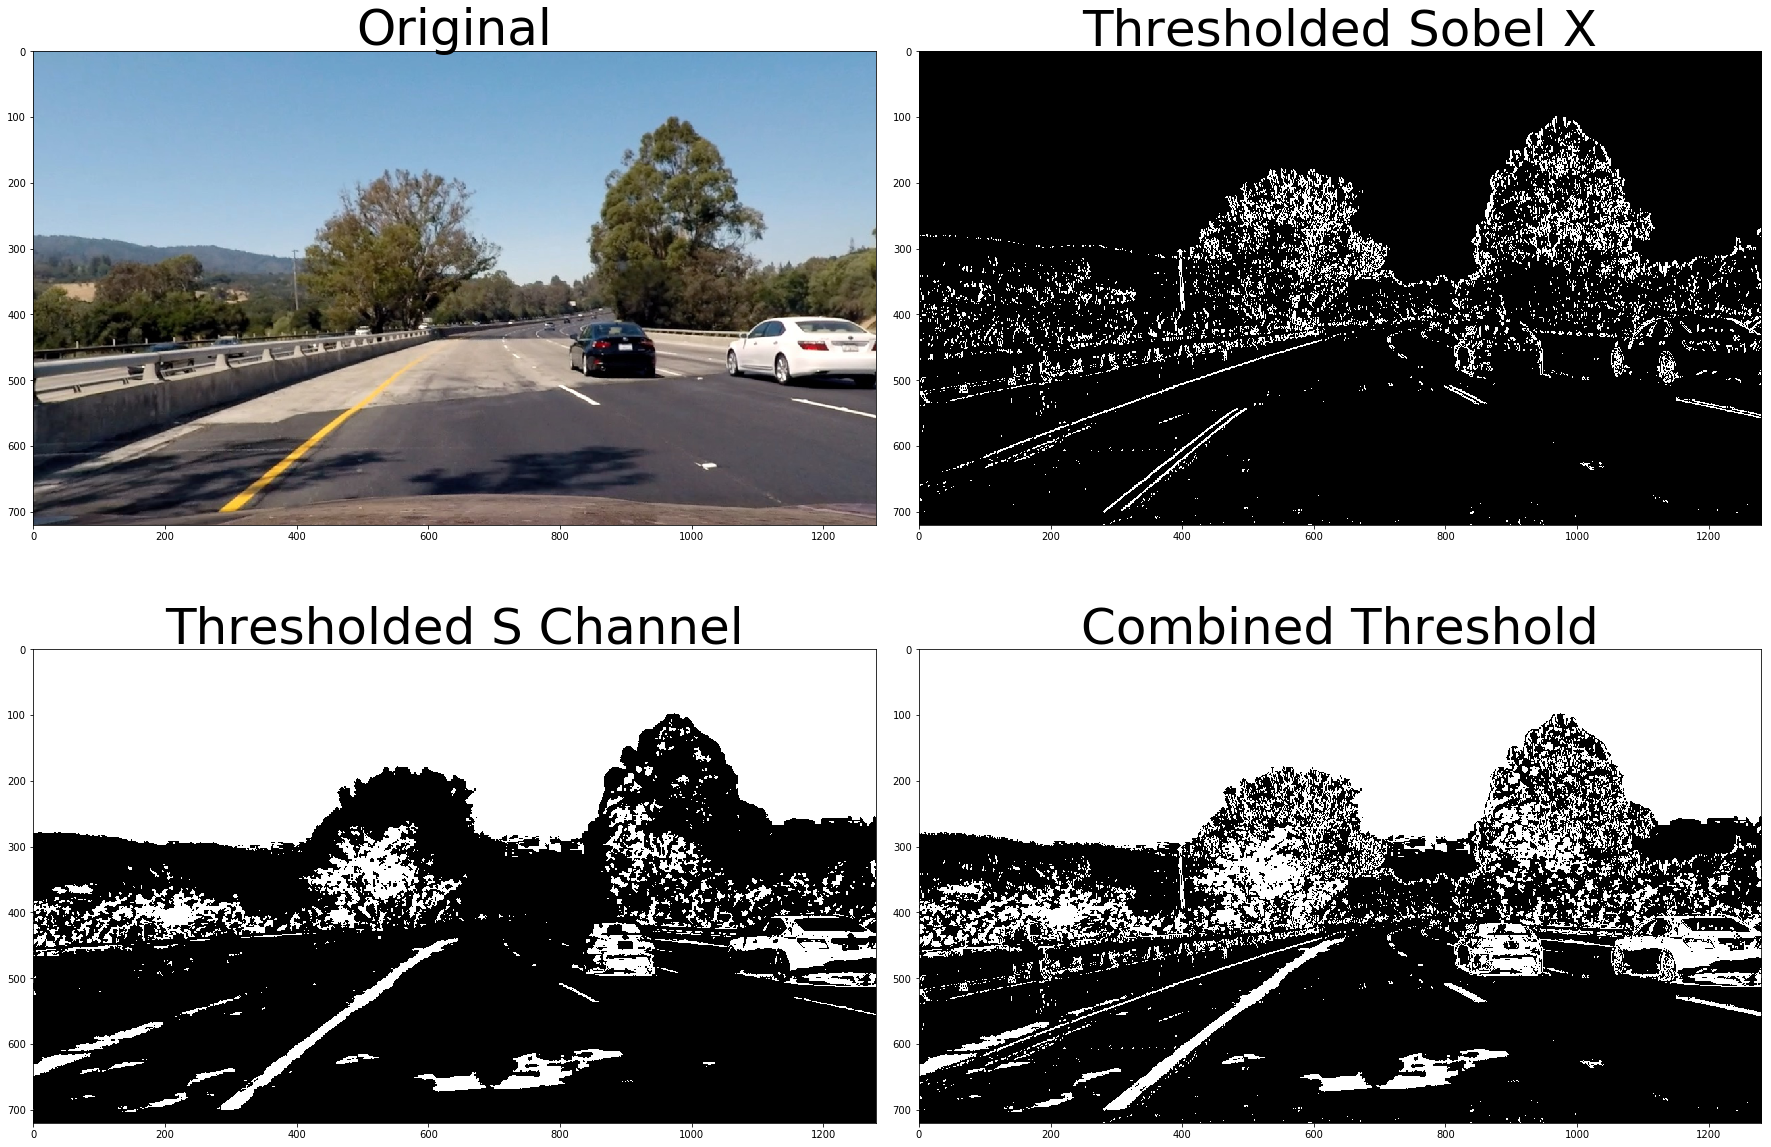

In [9]:
# Read image
image = mpimg.imread(test_images_paths[5]) # Choose image with light variation
image = cv2.undistort(image, mtx, dist, None, mtx)

# Thresholded Binary Image
bin_sobelx    = applyThresh(sobel_X(image), thresh=(20,100))
bin_s_channel = applyThresh(S_channel(image), thresh=(90,255))
bin_image     = binary_pipeline(image)

# Display
f, ax = plt.subplots(2, 2, figsize=(24, 18))  # width and heights in inches
f.tight_layout()
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
image_names  =[image         , bin_sobelx,
               bin_s_channel , bin_image  ]
image_labels =['Original','Thresholded Sobel X','Thresholded S Channel','Combined Threshold']
ax = ax.flatten()
for i in range(len(image_names)):
    ax[i].imshow(image_names[i], cmap='gray')
    ax[i].set_title(image_labels[i], fontsize=50)

## Locate Lane Lines 
#### Binary Bird's Eye View

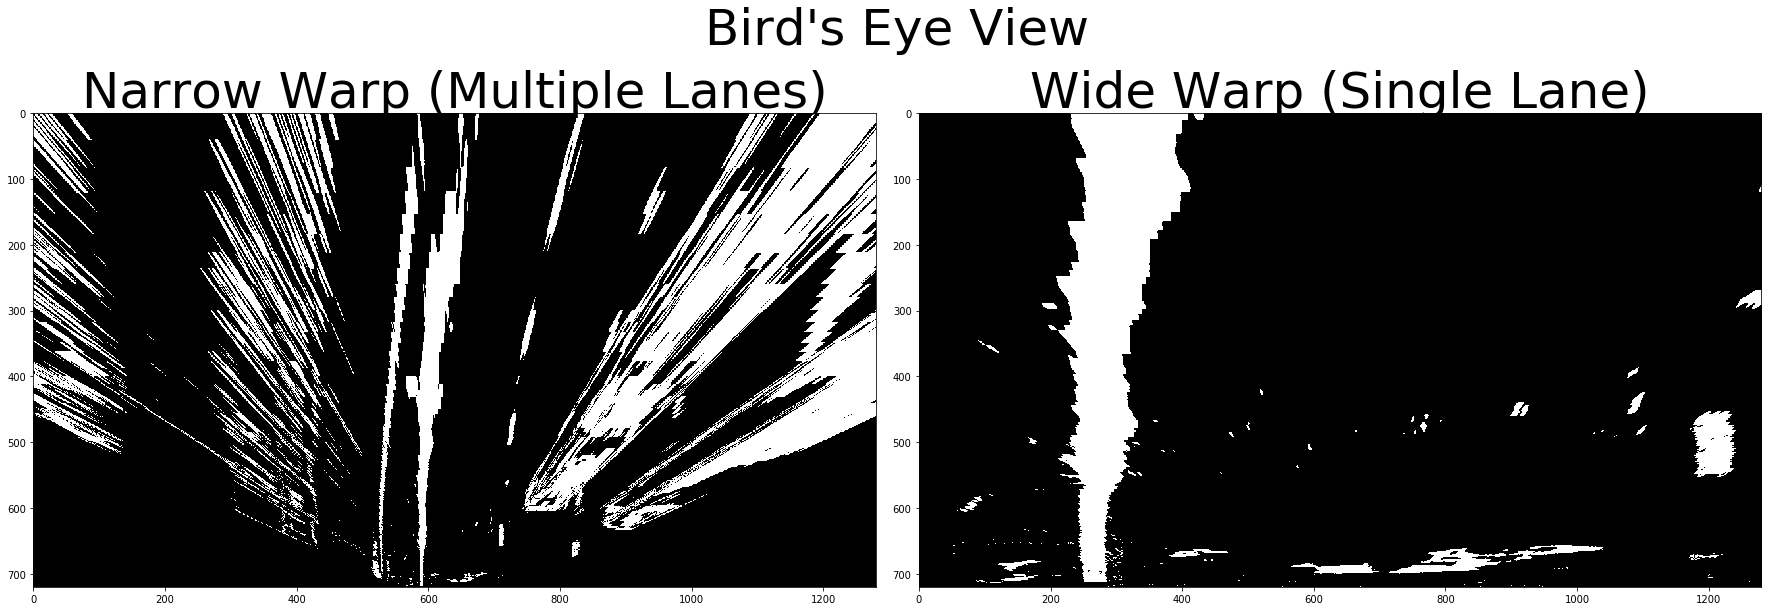

In [10]:
# Warp Binary Image
bin_warped_wide   = cv2.warpPerspective(bin_image, M_wide, (width,height))
bin_warped_narrow = cv2.warpPerspective(bin_image, M_narrow, (width,height))

# Display
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))  # width and heights in inches
f.tight_layout()
plt.suptitle("Bird's Eye View", fontsize=50)
ax1.set_title('Narrow Warp (Multiple Lanes)', fontsize=50)
ax1.imshow(bin_warped_narrow, cmap='gray')
ax2.set_title('Wide Warp (Single Lane)', fontsize=50)
ax2.imshow(bin_warped_wide, cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Helper Functions

In [11]:
def find_lane_pixels_in_sliding_window(binary_warped, nwindows=9, margin=100, minpix=50):
    """
    There is a left and right window sliding up independent from each other.
    This function returns the pixel coordinates contained within the sliding windows
    as well as the sliding windows midpoints
    PARAMETERS
    * nwindows : number of times window slides up
    * margin   : half of window's width  (+/- margin from center of window box)
    * minpix   : minimum number of pixels found to recenter window
    """
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    (height , width) = binary_warped.shape
    histogram = np.sum(binary_warped[int(height/2):,:], axis=0)
    window_leftx_midpoint  = np.argmax(histogram[:np.int(width/2)])
    window_rightx_midpoint = np.argmax(histogram[np.int(width/2):]) + np.int(width/2)

    # Set height of windows 
    window_height = np.int(height/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero  = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
  
    # Create empty lists 
    left_lane_inds  = []            # left lane pixel indices
    right_lane_inds = []            # Right lane pixel indices
    xleft_lane_win_midpts  = []     # left lane sliding window midpoints (x-coord)
    xright_lane_win_midpts = []     # Right lane sliding window midpoints (x-coord)
    
    # Step through the left and right windows one slide at a time
    for i in range(nwindows):
        # Identify right and left window boundaries 
        win_y_top       = height - (i+1)*window_height
        win_y_bottom    = height -   i  *window_height
        win_xleft_low   = max(window_leftx_midpoint  - margin , 0) 
        win_xleft_high  =     window_leftx_midpoint  + margin
        win_xright_low  =     window_rightx_midpoint - margin 
        win_xright_high = min(window_rightx_midpoint + margin , width)
        
        # Identify the nonzero pixels within the window and append to list
        good_left_inds  = ((nonzeroy >= win_y_top)      & (nonzeroy < win_y_bottom) & 
                           (nonzerox >= win_xleft_low)  & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_top)      & (nonzeroy < win_y_bottom) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.extend(good_left_inds)
        right_lane_inds.extend(good_right_inds)
        
        # Recenter next window midpoint If you found > minpix pixels and append previous midpoint
        xleft_lane_win_midpts.append(window_leftx_midpoint)
        xright_lane_win_midpts.append(window_rightx_midpoint)
        if len(good_left_inds  > minpix): window_leftx_midpoint  = np.mean(nonzerox[good_left_inds], dtype=np.int32)
        if len(good_right_inds > minpix): window_rightx_midpoint = np.mean(nonzerox[good_right_inds], dtype=np.int32)

    # Extract left and right line pixel positions
    xleft_lane  = nonzerox[left_lane_inds]
    yleft_lane  = nonzeroy[left_lane_inds] 
    xright_lane = nonzerox[right_lane_inds]
    yright_lane = nonzeroy[right_lane_inds]

    return (xleft_lane,yleft_lane), (xright_lane,yright_lane), (xleft_lane_win_midpts,xright_lane_win_midpts)


def draw_lane_pixels_in_sliding_window(binary_warped, left_lane_pts, right_lane_pts, window_midpts, margin=100):
    """
    Paints lane pixels and sliding windows.
    PARAMETERS
    * margin : half of window's width  (+/- margin from center of window box)
    """
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Unpack and Define variables
    (height , width) = binary_warped.shape
    (xleft_lane , yleft_lane)  = left_lane_pts
    (xright_lane, yright_lane) = right_lane_pts
    (xleft_lane_win_midpts, xright_lane_win_midpts) = window_midpts
    nwindows = len(xleft_lane_win_midpts)    # number of times window slided up
    window_height = int(height/nwindows)
    
    # Color left and right lane regions
    out_img[yleft_lane , xleft_lane]  = [255, 0, 0]
    out_img[yright_lane, xright_lane] = [0, 0, 255]
    
    # Draw the windows on the visualization image
    for i in range(nwindows):
        window_leftx_midpoint  = xleft_lane_win_midpts[i] 
        window_rightx_midpoint = xright_lane_win_midpts[i]
        win_y_top       = height - (i+1)*window_height
        win_y_bottom    = height -   i  *window_height
        win_xleft_low   = max(window_leftx_midpoint  - margin , 0) 
        win_xleft_high  =     window_leftx_midpoint  + margin
        win_xright_low  =     window_rightx_midpoint - margin 
        win_xright_high = min(window_rightx_midpoint + margin , width)
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_top),
                              (win_xleft_high,win_y_bottom),(0,255,0), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_top),
                              (win_xright_high,win_y_bottom),(0,255,0), 4) 
    return out_img


def ransac_polyfit(x, y, order=2, n=100, k=10, t=100, d=20, f=0.9):
    """
    RANSAC: finds and returns best model coefficients
    n – minimum number of data points required to fit the model
    k – maximum number of iterations allowed in the algorithm
    t – threshold value to determine when a data point fits a model
    d – number of close data points required to assert that a model fits well to data
    f – fraction of close data points required
    """
    besterr = np.inf
    bestfit = None
    if len(x) > 0:            #if input data not empty
        for kk in range(k):
            maybeinliers = np.random.randint(len(x), size=n)
            maybemodel = np.polyfit(x[maybeinliers], y[maybeinliers], order)
            alsoinliers = np.abs(np.polyval(maybemodel,x)-y) < t
            if sum(alsoinliers) > d and sum(alsoinliers) > len(x)*f:
                bettermodel = np.polyfit(x[alsoinliers], y[alsoinliers], order)
                thiserr = np.sum(np.abs(np.polyval(bettermodel,x[alsoinliers])-y[alsoinliers]))
                if thiserr < besterr:
                    bestfit = bettermodel
                    besterr = thiserr
    return bestfit


def fit_polynomial(img_height, left_lane_pts, right_lane_pts):
    """
    Returns pixel coordinates and polynomial coefficients of left and right lane fit.
    If empty lane pts are provided it returns coordinate (0,0) for left and right lane
    and sets fits to None.
    """
    # Unpack and Define variables 
    (xleft_lane , yleft_lane)  = left_lane_pts
    (xright_lane, yright_lane) = right_lane_pts

    try:
        # Fit a second order polynomial to each lane
        left_fit  = ransac_polyfit(yleft_lane , xleft_lane, order=2)
        right_fit = ransac_polyfit(yright_lane, xright_lane, order=2)
        #print(left_fit)
        #print(right_fit)
        
        # Generate x and y values of left and right fit
        ploty = np.linspace(0, img_height-1, img_height)
        left_fitx = np.polyval(left_fit, ploty)
        right_fitx = np.polyval(right_fit, ploty)
    
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('[WARNING] The function failed to fit a line!')
        ploty      = 0
        left_fitx  = 0
        right_fitx = 0
        left_fit   = None
        right_fit  = None

    return left_fit, right_fit, left_fitx, right_fitx, ploty


#### Fit Line Through Sliding Window Technique

(0, 1280)

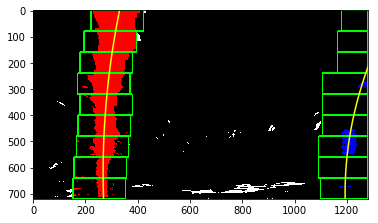

In [19]:
# Find pixels and Draw (Sliding Windows)
left_lane_pts, right_lane_pts, window_midpts = find_lane_pixels_in_sliding_window(bin_warped_wide)
img_out = draw_lane_pixels_in_sliding_window(bin_warped_wide, left_lane_pts, right_lane_pts, window_midpts)

# Get Line Fit
left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(height, left_lane_pts, right_lane_pts)

# Display
plt.imshow(img_out)
plt.plot(left_fitx, ploty , color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, width)

#### More Helper Functions

In [13]:
def find_lane_pixels_around_poly(binary_warped, left_fit, right_fit, margin = 100):
    """
    Returns the pixel coordinates contained within a margin from left and right polynomial fits.
    Left and right fits shoud be from the previous frame.
    PARAMETER
    * margin: width around the polynomial fit
    """
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Search within the +/- margin of the polynomial from previous frame 
    left_lane_inds  = ((nonzerox >= (np.polyval(left_fit,nonzeroy)-margin)) &  (nonzerox <= (np.polyval(left_fit,nonzeroy)+margin))).nonzero()[0]
    right_lane_inds = ((nonzerox >= (np.polyval(right_fit,nonzeroy)-margin)) &  (nonzerox <= (np.polyval(right_fit,nonzeroy)+margin))).nonzero()[0]
    
    # Extract left and right line pixel positions    
    xleft_lane  = nonzerox[left_lane_inds]
    yleft_lane  = nonzeroy[left_lane_inds] 
    xright_lane = nonzerox[right_lane_inds]
    yright_lane = nonzeroy[right_lane_inds]
    
    return (xleft_lane,yleft_lane), (xright_lane,yright_lane)


def draw_lane_pixels_around_poly(binary_warped, left_lane_pts, right_lane_pts, previous_fit_pts, margin=100):
    """
    Paints lane pixels and poly fit margins. Poly fit margins are based on previous frame values.
    PARAMETER
    * margin: width around the polynomial fit
    """
    # Create two output images to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img_margins = np.zeros_like(out_img)
    
    # Unpack and Define variables
    (height , width) = binary_warped.shape
    (xleft_lane , yleft_lane)  = left_lane_pts
    (xright_lane, yright_lane) = right_lane_pts
    (left_fitx, right_fitx, ploty) = previous_fit_pts
    
    # Color left and right lane pixels
    out_img[yleft_lane , xleft_lane]  = [255, 0, 0]   # Red
    out_img[yright_lane, xright_lane] = [0, 0, 255]   # Blue
    
    # Color left and right previous polynomial fit. NOTE: type of fit values are returned in float
    for cx,cy in zip(np.int_(left_fitx), np.int_(ploty)):
        cv2.circle(out_img, (cx,cy), radius= 1, color=[255, 0, 255], thickness=2)
    for cx,cy in zip(np.int_(right_fitx), np.int_(ploty)):
        cv2.circle(out_img, (cx,cy), radius= 1, color=[255, 0, 255], thickness=2)    
                
    # Draw polynomial margins
    # Generate a polygon to illustrate the search area. NOTE: you flip array to keep contour when cv2.fillPoly
    left_line_left_margin  = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_right_margin = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))]) 
    left_line_margin_pts   = np.hstack((left_line_left_margin, left_line_right_margin))
    
    right_line_left_margin  = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_right_margin = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
    right_line_margin_pts   = np.hstack((right_line_left_margin, right_line_right_margin))

    cv2.fillPoly(out_img_margins, np.int_([left_line_margin_pts]), (0,255, 0))
    cv2.fillPoly(out_img_margins, np.int_([right_line_margin_pts]), (0,255, 0))
    
    # Combine output images
    result = cv2.addWeighted(out_img, 1, out_img_margins, 0.3, 0)
    
    return result


#### Fit Line Around Previous Polynomial Fit 
We will slightly shift the original binary image to create the illusion of the next current frame

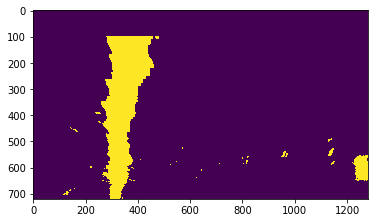

In [14]:
# Create "Next" Binary Frame by translation
tx = 50      # translate in x
ty = 100     # translate in y
M  = np.float32([[1,0,tx],[0,1,ty]])
next_frame = cv2.warpAffine(bin_warped_wide, M, (width,height))     

# Display
plt.imshow(next_frame)

(0, 1280)

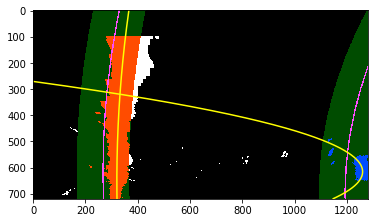

In [20]:
# Find pixels and Draw (Around Previous lane fit)
left_lane_pts, right_lane_pts = find_lane_pixels_around_poly(next_frame, left_fit, right_fit)
previous_fit_pts = (left_fitx, right_fitx, ploty)
img_out = draw_lane_pixels_around_poly(next_frame, left_lane_pts, right_lane_pts, previous_fit_pts)

# Get Line Fit
new_left_fit, new_right_fit, new_left_fitx, new_right_fitx, ploty = fit_polynomial(height, left_lane_pts, right_lane_pts)

# Display
plt.imshow(img_out)
plt.plot(new_left_fitx, ploty , color='yellow')
plt.plot(new_right_fitx, ploty, color='yellow')
plt.xlim(0, width)

In the right lane, the search of pixels around previous fit was a success; however, the new line fit in yellow for the pixels highlighted in blue failed to continue the shape of the previous line fit in purple.

Even though we could apply RANSAC and correct for this, it might be computationally expensive to overtune its parameters. Therefore, we will weight more the previous line fit when finding the new line fit. This can be resolved by artificially adding points around the previous fit before finding the new fit. Let's try again!

(0, 1280)

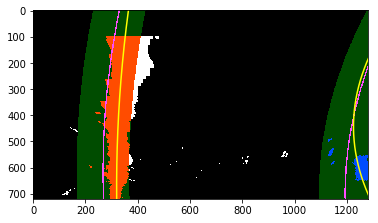

In [22]:
def augment_previous_fit_pts(left_lane_pts, right_lane_pts, previous_fit_pts):
     # Unpack and Define variables
    (xleft_lane , yleft_lane)  = left_lane_pts
    (xright_lane, yright_lane) = right_lane_pts
    (left_fitx, right_fitx, ploty) = previous_fit_pts

    # Augment
    left_lane_pts_aug  = (np.hstack((xleft_lane,left_fitx))  , np.hstack((yleft_lane,ploty)))
    right_lane_pts_aug = (np.hstack((xright_lane,right_fitx)), np.hstack((yright_lane,ploty)))

    return left_lane_pts_aug, right_lane_pts_aug


# Find pixels and Draw (Around Previous lane fit)
left_lane_pts, right_lane_pts = find_lane_pixels_around_poly(next_frame, left_fit, right_fit)
previous_fit_pts = (left_fitx, right_fitx, ploty)
img_out = draw_lane_pixels_around_poly(next_frame, left_lane_pts, right_lane_pts, previous_fit_pts)

# Get Line Fit
left_lane_pts_aug, right_lane_pts_aug = augment_previous_fit_pts(left_lane_pts, right_lane_pts, previous_fit_pts)
new_left_fit, new_right_fit, new_left_fitx, new_right_fitx, ploty = fit_polynomial(height, left_lane_pts_aug, right_lane_pts_aug)

# Display
plt.imshow(img_out)
plt.plot(new_left_fitx, ploty , color='yellow')
plt.plot(new_right_fitx, ploty, color='yellow')
plt.xlim(0, width)

## [Radius of Curvature](https://www.intmath.com/applications-differentiation/8-radius-curvature.php)

In [ ]:
def measure_curvature_pixels(img_height, right_fit, ploty):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define where we want radius of curvature
    y_eval = img_height  # We'll choose the maximum y-value, corresponding to the bottom of the image
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


In [ ]:
import numpy as np

def generate_data(ym_per_pix, xm_per_pix):
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return ploty, left_fit_cr, right_fit_cr
    
def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real()

print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

## Lane Detector Pipeline
Makes use of helper functions to return image with lanes detected.

In [17]:
https://www.mrt.kit.edu/download/Multi_Lane_Detection_and_Ego_Lane_Estimation(1).pdf

SyntaxError: invalid syntax (<ipython-input-17-5c347d5466de>, line 1)

In [ ]:
# try:
#     find_lane_pixels_around_poly(binary_warped, left_fit, right_fit, margin = 100):
    
# except TypeError:  
#     find_lane_pixels_in_sliding_window